In [1]:
#Imports
from skimage import io
from skimage.color import rgb2grey
from skimage.morphology import skeletonize
from skimage.color import rgb2lab,gray2rgb
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle
from _frangi import frangi, hessian
from skimage.filters import threshold_li
from skimage import morphology
import warnings as war
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from os import walk
from os import path
from scipy.ndimage.filters import prewitt
import csv

#Importar imágenes
def csvReader(csvPath):
    rows = []
    with open(csvPath, newline='') as csvfile:
        perfiles = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
        for row in perfiles:
            rows.append(row)
    return rows  

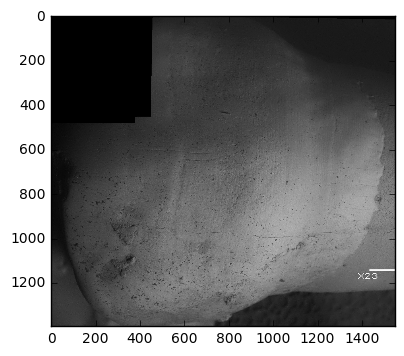

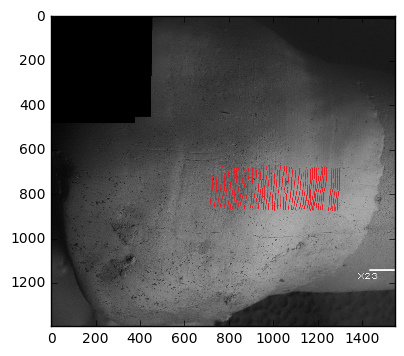

In [2]:
# Importar imágenes
fullImage = io.imread('Optimize\\Image.bmp')
fullMask = io.imread('Optimize\\Mask2.bmp')
fullCsv = csvReader('Optimize\\linea.csv')

plt.figure()
plt.imshow(fullImage)

plt.figure()
plt.imshow(fullMask)

In [3]:
# Funcion sobre la que modificar parametros
def processImage(img, clipLimit, nb, pwtParam, w, removeSmall, conn):
    """
    Apply some filters to the given image.
    :param img: image to process
    :param clipLimit: clip_limit parameter (0,1)
    :param nb: nbins parameter (0,100)
    :param pwt: prewitt parameter
    :param w: weight parameter (0,1)
    :param removeSmall: min_size parameter (0,100)
    :param conn: connectivity parameter (0,100)
    :return: processed image
    """
    result = None
    # disable warnings
    with war.catch_warnings():
        war.simplefilter("ignore")
        # Convert image to grey scale
        img = rgb2grey(img)
        try:
            # Equalize histogram
            imgAdapted = exposure.equalize_adapthist(img, clip_limit=clipLimit, nbins=nb)
            # Reduce noise
            imgAdaptedDenoise = denoise_tv_chambolle(imgAdapted, weight=w)
            # Apply Prewitt
            pwt = prewitt(imgAdaptedDenoise, -1, None, 'constant', pwtParam)
            # Apply frangi filter
            frangiImg = frangi(pwt)
            # Calculate image threshold
            threshold = threshold_li(frangiImg)
            # Apply threshold
            thresholdedImg = frangiImg >= threshold
            # Skeletonize image
            skImg = skeletonize(thresholdedImg)
            # Remove small objects (min_size fixed to 70)
            result = morphology.remove_small_objects(skImg, min_size=removeSmall, connectivity=conn)
        except:
            #print(clipLimit)
            #print(nb)
            raise 
    return result

In [4]:
# Funcion processImage con parametros innecesarios quitados
def processImage2(img, clipLimit, nb, w, removeSmall, conn):
    """
    Apply some filters to the given image.
    :param img: image to process
    :param clipLimit: clip_limit parameter (0,1)
    :param nb: nbins parameter (0,100)
    :param w: weight parameter (0,1)
    :param removeSmall: min_size parameter (0,100)
    :param conn: connectivity parameter (0,100)
    :return: processed image
    """
    result = None
    # disable warnings
    with war.catch_warnings():
        war.simplefilter("ignore")
        # Convert image to grey scale
        img = rgb2grey(img)
        try:
            # Equalize histogram
            imgAdapted = exposure.equalize_adapthist(img, clip_limit=clipLimit, nbins=nb)
            # Reduce noise
            imgAdaptedDenoise = denoise_tv_chambolle(imgAdapted, weight=w)
            # Apply Prewitt
            pwt = prewitt(imgAdaptedDenoise)
            # Apply frangi filter
            frangiImg = frangi(pwt)
            # Calculate image threshold
            threshold = threshold_li(frangiImg)
            # Apply threshold
            thresholdedImg = frangiImg >= threshold
            # Skeletonize image
            skImg = skeletonize(thresholdedImg)
            # Remove small objects (min_size fixed to 70)
            result = morphology.remove_small_objects(skImg, min_size=removeSmall, connectivity=conn)
        except:
            #Los print siempre muestran lo mismo: 0.1,1
            #print(clipLimit)
            #print(nb)
            raise
    return result

In [5]:
#Funcion a optimizar. From wiki.
def distance(str1, str2):
    """
    Distancia de Levenshtein
    """
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [6]:
"Función de Ismael"
def distancia_al_rojo(img, pixel):
        """
        Metodo para:
        Pasamos la imagen al espacio de color RGB y nos quedamos con el canal rojo
        Pasamos la imagen al espacio de color HSV
        Normalizamos la imagen del espacio de color HSV para utilizar que distancia 
        al rojo tenemos y poder hacer el theshold.
        
        @param img: imagen original leida anteriormente.
        @return: distance_red: distancia de cada pixel al rojo para luego hacer el threshold.
        
        """ 
        r,g,b = pixel        
        g,v,b=rgb2lab([[[r/255,g/255,b/255]]])[0][0]
        
        lab=rgb2lab(img)
        distance_red=abs(lab - [g,v,b]).mean(axis=2)
        return distance_red
    
def tratamientoMascara(mask):
    """
    Función para binarizar la máscara y esqueletonizarla
    @param mask mascara
    @return skelMask mascara binarizada y esqueletonizada
    """
    mskRojo = distancia_al_rojo(mask, [255, 0, 0])

    #Valor fijo para que no interfiera con la binarizacion
    binMask = mskRojo<20
    
    plt.figure()
    plt.imshow(binMask)
    skelMask = skeletonize(binMask);
    return skelMask   

def generarCSV():
    xIni = 709
    yIni = 717    
    xFin = 1315
    
    profileX =list()
    profileY=list()
    for i in range(xFin-xIni+1):
        profileX.append(xIni+i)
        profileY.append(yIni)
        np.savetxt("Optimize\\linea.csv", np.column_stack((profileX, profileY)), delimiter=",", fmt='%s')
        
generarCSV()

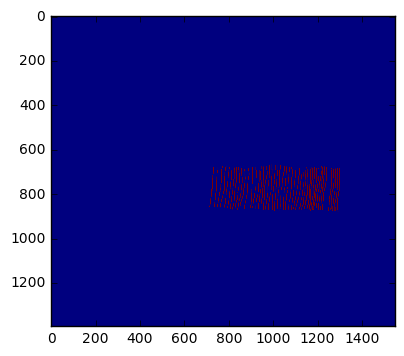

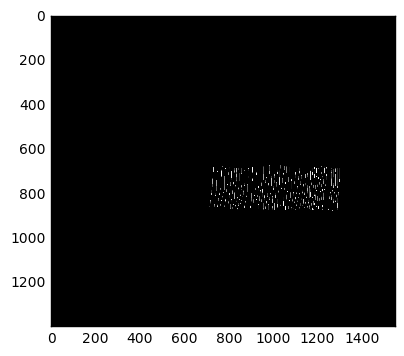

In [7]:
#Mascara
mask = tratamientoMascara(fullMask)
plt.figure()
plt.imshow(mask, cmap='gray')

In [8]:
def getDifferences(img1, img2, csvItem):
    """
    Devuelve una lista con las diferencias en cada linea de las imágenes
    @param img1 imagen 1
    @param img2 imagen 2
    @param csv csv donde se encuentran los pixels de la imagen que hay que evaluar
    @return lista de diferencias
    """
    #Obtener los puntos de las imagenes a evaluar segun los pixels marcados en el csv
    pixels1 = list()
    pixels2 = list()
    for row in csvItem:
        pixels1.append(img1[int(row[1])][int(row[0])])
        pixels2.append(img2[int(row[1])][int(row[0])])
    return distance(pixels1, pixels2)

# Anterior
def minimizar(clipLimit, nb, pwtParam, w, removeSmall, conn):
    result = processImage(fullImage, clipLimit, nb, pwtParam, w, removeSmall, conn)
    differences = getDifferences(result, mask, fullCsv)
    return differences

In [9]:
counter = list()
diffecencesList = list()

In [10]:
def minimizar(args):
    counter.append(0)
    try:
        clipLimit, nb, w, removeSmall, conn = args
        result = processImage2(fullImage, clipLimit, nb, w, removeSmall, conn)
        #result = processImage2(fullImage, args[0], args[1], args[2], args[3], args[4])
        differences = getDifferences(result, mask, fullCsv)
        diffecencesList.append(differences)
        return differences
    except:
        diffecencesList.append('Error')
        return 9999

#args[0]  args[1] args[2] args[3] args[4] args[5]
#clipLimit, nb, pwtParam, w, removeSmall, conn

In [11]:
import scipy.optimize as op
from time import time

#bnds = ((0.01,1.00),(1,100),(0.1,2.0),(0.1,1.0),(1,100),(1,100))
#bnds = ([0.1,1.0,10.0], [1,200,15], [0.1,1.0,10.0], [1,100,10], [1,100,10])

bnds = (slice(0.1,1.0,9), slice(1,201,15), slice(0.1,1.0,9), slice(1,100,9), slice(1,100,9))

t1 = time()
#Argumento finish=None para que respete los rangos introducidos
funcion = op.brute(minimizar, bnds, finish=None)
t2= time()
#Optimo
print(funcion)

#Tiempo empleado (minutos)
print((t2-t1)/60)

#Veces que se ejecuta la función
print(len(counter))

[ 0.1  1.   0.1  1.   1. ]
7.585077563921611
1695


In [12]:
#Comprobacion
j = 0
for i in diffecencesList:
    if i == 'Error':
        j=j+1

if j == len(diffecencesList):
    print('Siempre salta la excepcion')

Siempre salta la excepcion


In [15]:
t1 = time()
#Tiempo para procesar una imagen
funcion = processImage(fullImage,0.91,100,0,0.1,0,100)
t2= time()

0.13834851185480754
2766.970237096151


In [16]:
print((t2-t1)/60)
print(10*20*10*10*(((t2-t1)/60)/60))

0.13834851185480754
46.11617061826918
